### Fine-Tuning Llama-2-7b-Chat Model using PEFT and 4-bit Quantization

This notebook demonstrates the fine-tuning of the `meta-llama/Llama-2-7b-chat-hf` model using PEFT (Parameter-Efficient Fine-Tuning) with 4-bit quantization. We'll use the Hugging Face `transformers`, `bitsandbytes`, and `peft` libraries for this task.

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## Import Libraries
Next, we import the required libraries and define our model parameters:

In [61]:
import os
import torch
import random
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import matplotlib.pyplot as plt

## Define Model and Training Parameters
Specify the model name, fine-tuned model name, LoRA configuration, and training parameters:

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "/content/drive/MyDrive/intel/intel_split1/Llama-2-7b-chat-finetune-final"

In [4]:
# LoRA configuration
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# Quantization configuration
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Training parameters
output_dir = "./results"
fp16 = False
bf16 = False
num_train_epochs = 5
per_device_train_batch_size = 4
per_device_eval_batch_size = 4

In [5]:
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3

learning_rate = 3e-4
weight_decay = 0.001

optim = "paged_adamw_32bit"
lr_scheduler_type = "linear"
max_steps = -1
warmup_ratio = 0.03

group_by_length = True
save_steps = 0
logging_steps = 25

max_seq_length = None
packing = False
device_map = {"": 0}

## Load Dataset
Load the dataset and split it into training and testing sets:

In [6]:
dataset_dir = "/content/intel"
dataset = load_dataset(dataset_dir, split="train")
dataset = dataset.train_test_split(test_size=0.1)  # Split into 90-10 train-test split

Generating train split: 0 examples [00:00, ? examples/s]

## Configure Quantization
Set up the quantization configuration for 4-bit quantization:

In [7]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [8]:
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

## Log in to Hugging Face Hub
Log in to the Hugging Face Hub to access the model:

In [9]:
from huggingface_hub import notebook_login
notebook_login()

## Load Model and Tokenizer
Load the model and tokenizer from the Hugging Face Hub:

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:81: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Configure PEFT
Set up the PEFT configuration using LoRA:

In [12]:
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

## Training Arguments
Define the training arguments:

In [13]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
    do_eval=True,
    per_device_eval_batch_size=per_device_eval_batch_size,
    evaluation_strategy="steps",
)

## Initialize Trainer
Initialize the trainer with the model, dataset, and training arguments:


In [14]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

## Train the Model
Train the model and save the fine-tuned model:

In [15]:
# Train the model and save training and validation logs
train_result = trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,2.990800,1.882263
50,1.883100,1.130746
75,0.941700,1.013794
100,1.637200,0.963295
125,0.740300,0.917466
150,1.265900,0.875432
175,1.078700,0.862690
200,0.902600,0.800834
225,1.031300,0.784357
250,0.610600,0.748927


In [16]:
trainer.model.save_pretrained(new_model)

## Plot Training and Validation Loss
Extract and plot the training and validation loss:

In [17]:
history = trainer.state.log_history

In [18]:
train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

In [19]:
train_steps = [log['step'] for log in train_logs]
train_losses = [log['loss'] for log in train_logs]
eval_steps = [log['step'] for log in eval_logs]
eval_losses = [log['eval_loss'] for log in eval_logs]

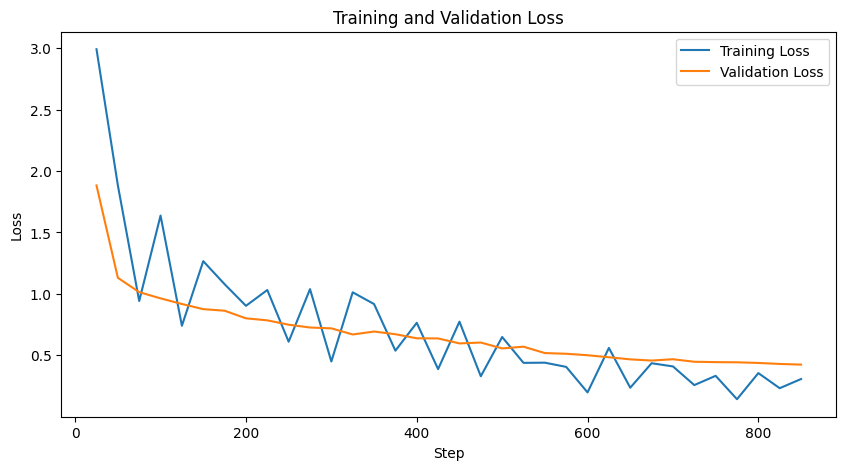

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()